# Bubble Analysis

## Abstract

Analyze Hass Door part numbers of complete doors where at least one section presented a buble caused by the expansion of gas trapped between the exterior skin and foam.

## Data

Data will be imported from Microsoft Excel files in the following format:

![alt text](assets/image.png)

The file can contain multiple sheets and all sheets will be imported and concatinated if `use_all_sheets = True`.

Columns can be added to the data by modifying `columns = ['Line', 'Blend','EndOfPourTimeStamp', 'SmartPartNumber', 'Order Number']`.

### Open XLSX and Convert to CSV


In [1]:
# Import XLSX and convert to CSV
import xlsx_to_csv as xtc

files = ['order_history.xlsx', 'orders_with_bubbles.xlsx', 'sections_with_bubbles.xlsx']
columns = ['Order', 'Serial', 'SmartPartNumber', 'Line', 'Blend', 'EndOfPourTimeStamp']
overwrite_existing = False
use_all_sheets = True

# convert the XLSX file to CSV
for file in files:
    csv_file = xtc.xls_to_csv(file, columns, overwrite_existing, use_all_sheets)

order_history.csv already exists!
orders_with_bubbles.csv already exists!
sections_with_bubbles.csv already exists!


In [2]:
# Load CSV into dataframes
import pandas as pd
import haas_section as hs
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("Loading data . . .")
df = pd.read_csv('order_history.csv')
df.attrs['name'] = "order_history"
df_owb = pd.read_csv('orders_with_bubbles.csv')
df_owb.attrs['name'] = "orders_with_bubbles"
df_swb = pd.read_csv('sections_with_bubbles.csv')
df_swb.attrs['name'] = "sections_with_bubbles"

# Add column to indicate that at least one section
# on the order had a bubble
df_owb['Bubble on Order']= True
df_owb['Bubble on Order'] = df_owb['Bubble on Order'].astype(bool)

# Add column to indicate that the section as a bubble
df_swb['Bubble']=  True
df_swb['Bubble'] = df_swb['Bubble'].astype(bool)

bubble_list = df_swb['Serial'].values.tolist()
count = df['Serial'].isin(bubble_list).sum()

print(f'There are {count} of {len(bubble_list)} bubble sections in the master list.')

# Merge orders with bubbles that includes 
# 'Bubble on Order' bool to all orders
df = pd.merge(df, df_owb[['Order','Bubble on Order']], how='outer', on='Order')

# Merge sections with bubbles that includes 
# 'Bubble' bool to all orders
df = pd.merge(df, df_swb[['Serial', 'Bubble']], how='outer', on='Serial')

# Fill in the False values
pd.set_option('future.no_silent_downcasting', True)
df['Bubble'] = df['Bubble'].fillna(False)
df['Bubble on Order'] = df['Bubble on Order'].fillna(False)
df.loc[df['Bubble'], 'Bubble on Order'] = True

data_frames = [df, df_owb, df_swb ]
# disect the part number and make columns for each definition
for mydf in data_frames:
    for option, loc in hs.ht_part_number.items():
        mydf[option] = mydf['SmartPartNumber'].str[loc[0]:loc[1]]

    # # convert EndOfPourTimeStamp into date/time object
    # # then make Year, Month and Day and Hour columns
    mydf['EndOfPourTimeStamp'] = pd.to_datetime(mydf['EndOfPourTimeStamp'])
    mydf['EndOfPourTimeStamp'] = mydf['EndOfPourTimeStamp'].dt.round(freq='15min')
    mydf['Weekday'] = mydf['EndOfPourTimeStamp'].dt.day_name()
    mydf['Year'] = mydf['EndOfPourTimeStamp'].dt.year
    mydf['Day of Year'] = mydf['EndOfPourTimeStamp'].dt.day_of_year
    mydf['Week'] = mydf['EndOfPourTimeStamp'].dt.isocalendar().week
    mydf['Month'] = mydf['EndOfPourTimeStamp'].dt.month
    mydf['Hour'] = mydf['EndOfPourTimeStamp'].dt.hour
    # mydf['Time'] = mydf['EndOfPourTimeStamp'].dt.time

firstDate, lastDate = df['EndOfPourTimeStamp'].min(), df['EndOfPourTimeStamp'].max()
print(f'From {firstDate} to {lastDate}')

# df.to_csv("orders_history_df.csv")
# df_owb.to_csv("orders_with_bubbles_df.csv")
# df_swb.to_csv("sections_with_bubbles_df.csv")

# delete the original EndOfPourTimeStamp 
df.drop('EndOfPourTimeStamp', axis=1, inplace=True)
# delete the SmartPartNumber 
df.drop('SmartPartNumber', axis=1, inplace=True)
# delete the Order Number 
df.drop('Order', axis=1, inplace=True)
# delete the Serial Number 
df.drop('Serial', axis=1, inplace=True)

df_shape = df.shape
df.dropna(inplace=True)
df_new_shape = df.shape

dropped_rows = df_shape[0] - df_new_shape[0]
print(f'*{dropped_rows} rows were dropped due to incomplete data.')

# remove uniform columns
uniform_columns = [col for col in df.columns if df[col].nunique() == 1]
for col in uniform_columns:
    print(f'"{col}" contain homogeneous data and has been removed.')
df = df.drop(columns=uniform_columns)

# df.to_csv("bubbles.csv")

Loading data . . .
There are 60 of 60 bubble sections in the master list.
From 2020-01-02 06:45:00 to 2024-09-14 12:30:00
*32 rows were dropped due to incomplete data.
"Inside Grooving" contain homogeneous data and has been removed.


Index Count: 12


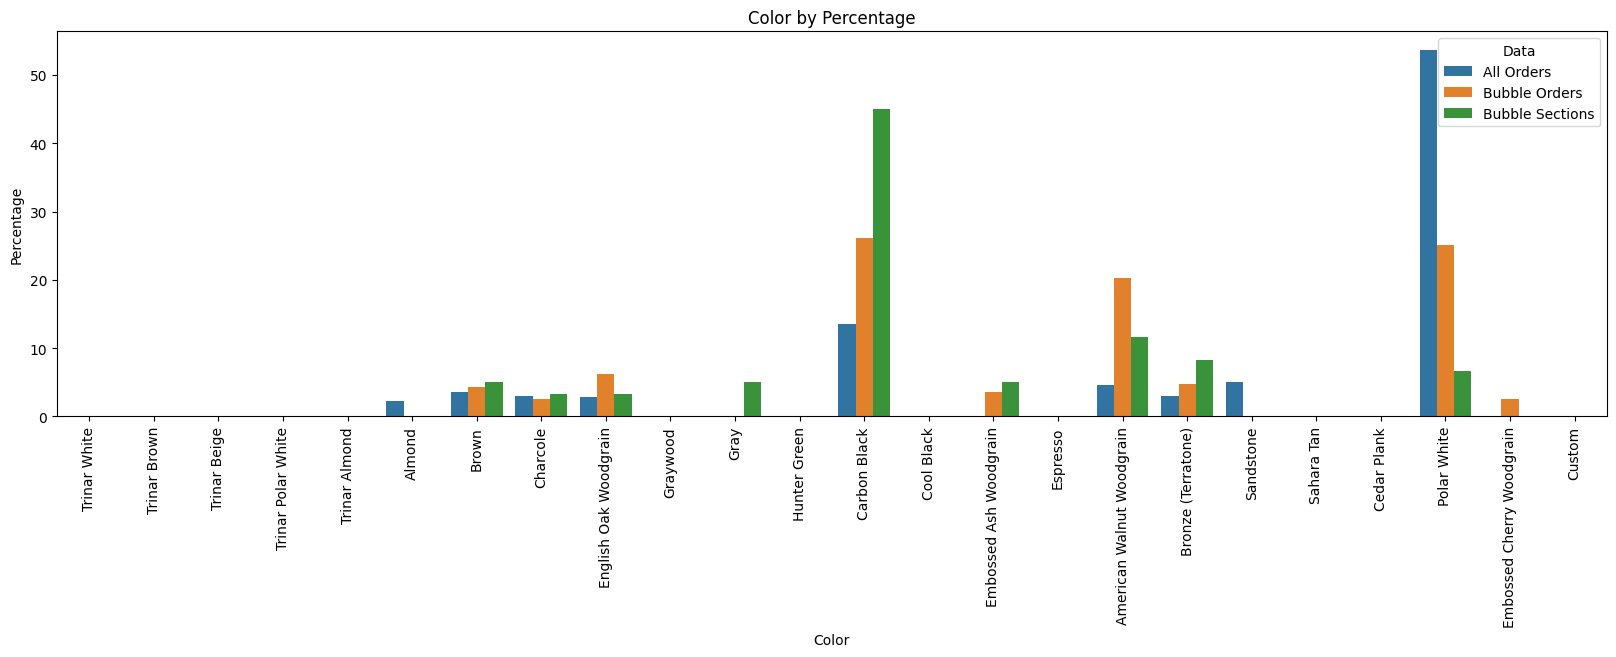

Index Count: 24


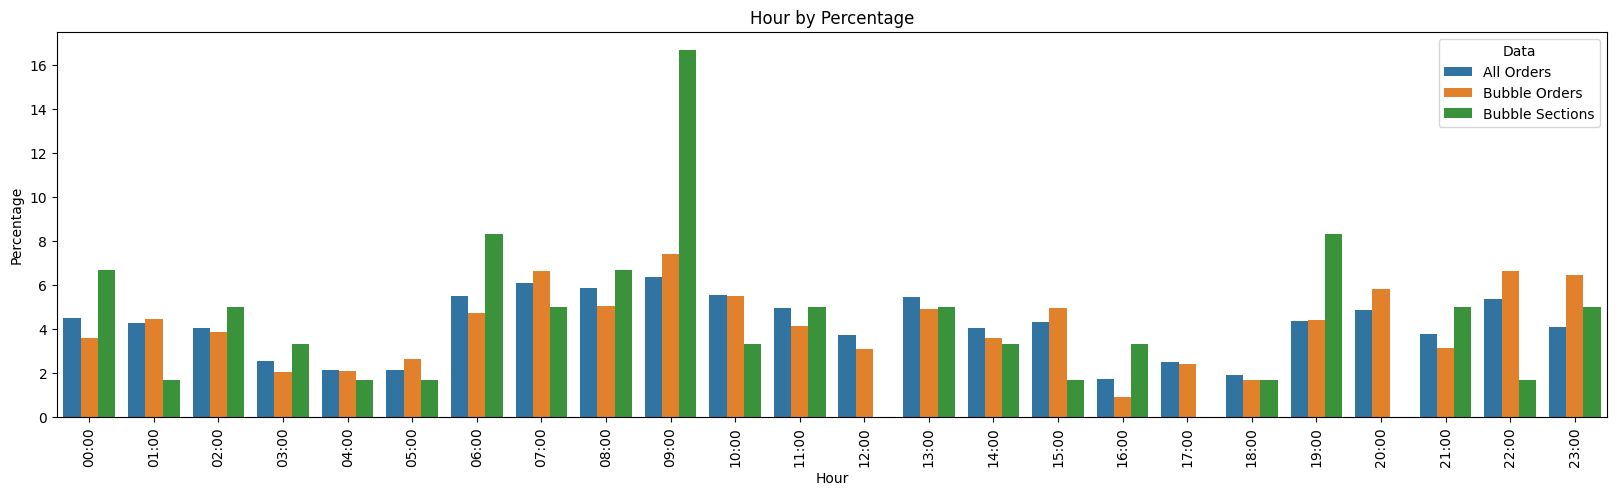

Index Count: 7


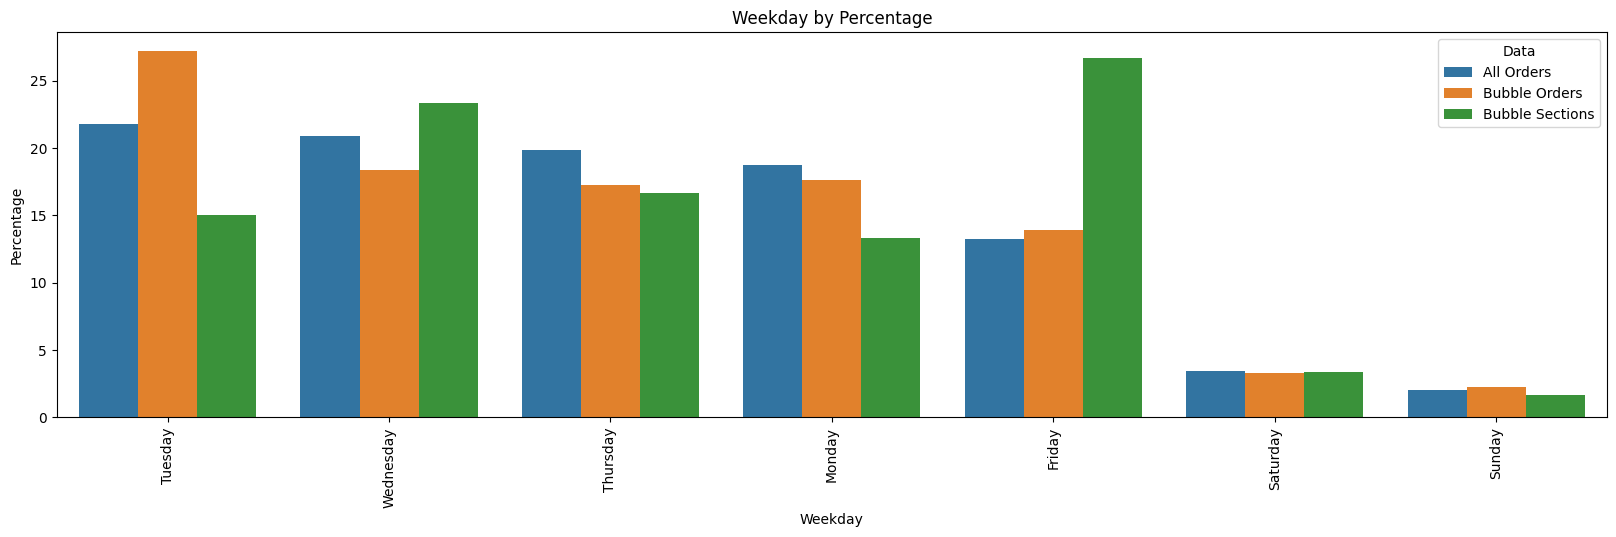

Index Count: 12


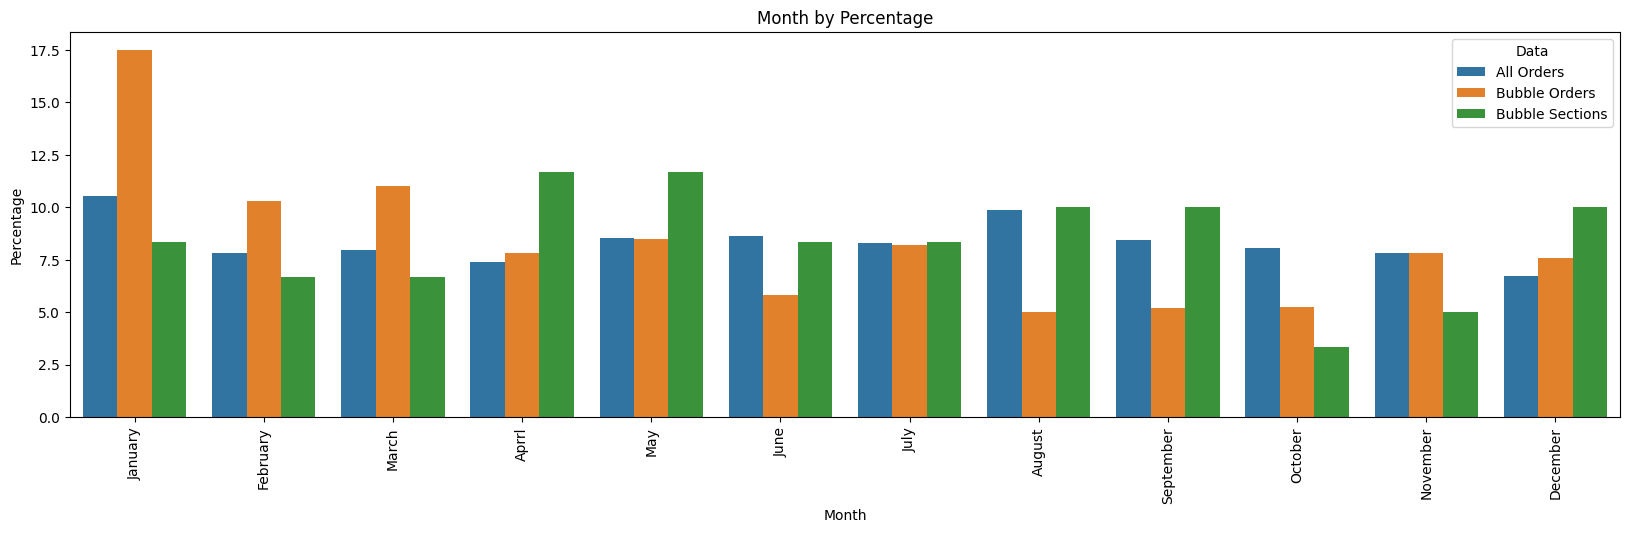

Index Count: 53


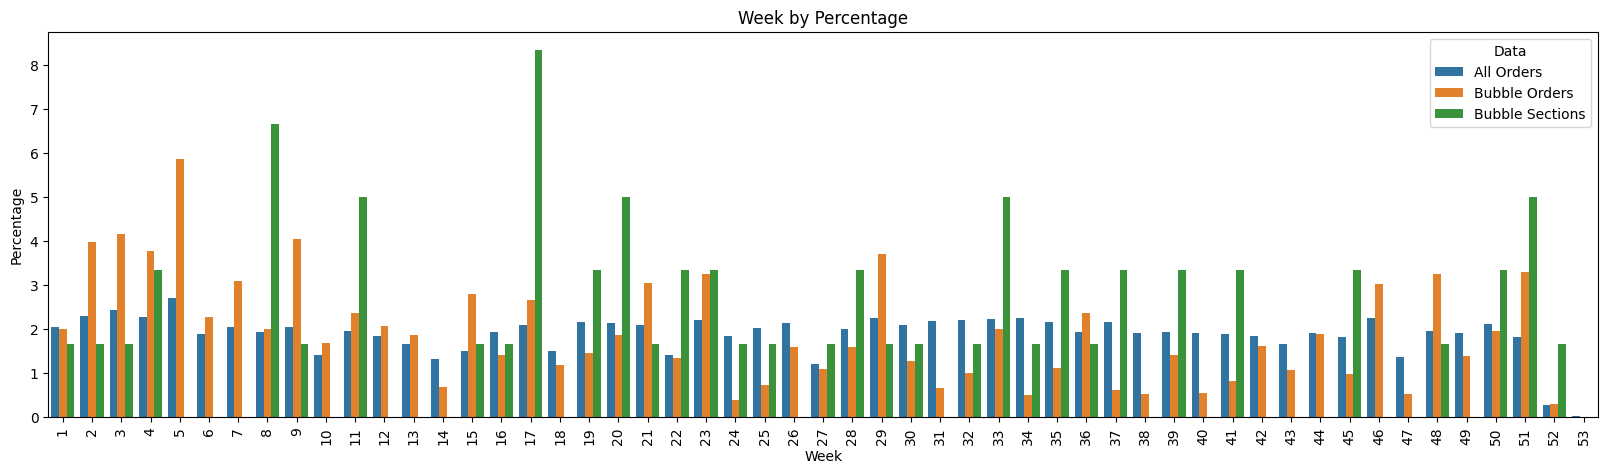

Index Count: 360


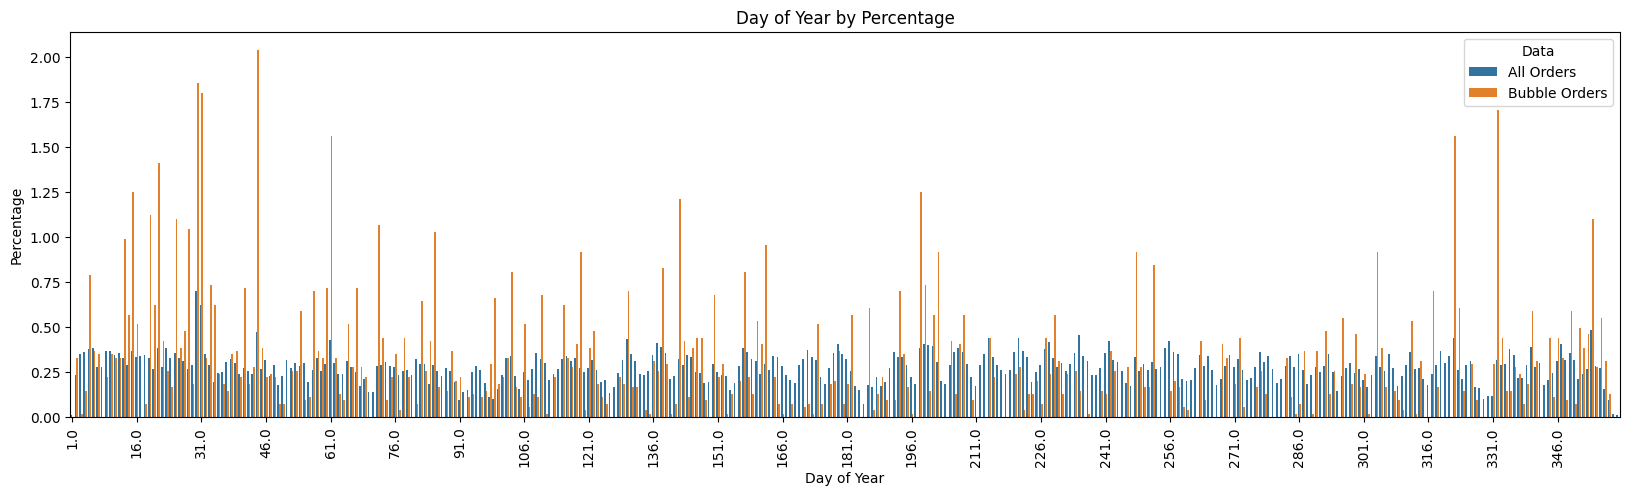

Index Count: 6


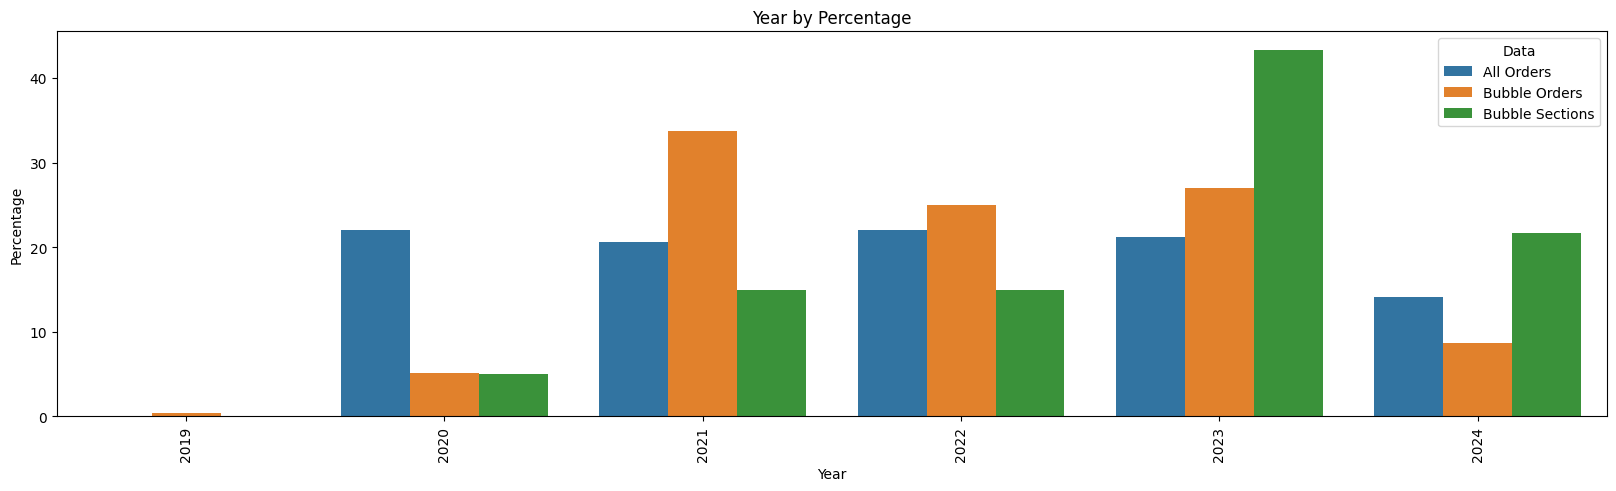

In [3]:
from barchart import barchart
import haas_section as hds
import dates as dt

barchart('Color', df, df_owb, df_swb, hds.color, 2)
barchart('Hour', df, df_owb, df_swb, dt.hour)
barchart('Weekday', df, df_owb, df_swb)
barchart('Month', df, df_owb, df_swb, dt.month)
barchart('Week', df, df_owb, df_swb)
barchart('Day of Year', df, df_owb)
barchart('Year', df, df_owb, df_swb, dt.year)


In [4]:
print(len(df_swb.index.unique()))

60


## Correlation Matrix

The correlation matrix will contain the Pearson correlation coefficients between each pair of variables. A value closer to 1 indicates a strong positive relationship, while values closer to -1 indicate a strong negative relationship. Values close to zero suggest no linear relationship between two variables.


In [5]:
# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to all categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Calculate Pearson correlation (default)
pearson_corr = df.corr()

# Calculate Spearman correlation
spearman_corr = df.corr(method='spearman')

# Calculate Kendall correlation
kendall_corr = df.corr(method='kendall')

correlation_matrix = pearson_corr

# Print the correlation matrix
print(correlation_matrix)
# Identify the most correlated variables
most_correlated_variables = correlation_matrix.unstack().sort_values(ascending=False)[1:]

# Print the most correlated variables
print('Most correlated variables:')
print(most_correlated_variables)

                            Line     Blend  Bubble on Order    Bubble  \
Line                    1.000000  0.002972        -0.086303 -0.002924   
Blend                   0.002972  1.000000        -0.003943  0.002431   
Bubble on Order        -0.086303 -0.003943         1.000000  0.031442   
Bubble                 -0.002924  0.002431         0.031442  1.000000   
Type                    0.098450 -0.004692         0.014910 -0.005846   
Height                  0.198113  0.025612         0.037040  0.003425   
Construction            0.092193 -0.459190        -0.233606 -0.001436   
Color                   0.085780 -0.000655        -0.013568 -0.004920   
Thickness              -0.201832  0.054244         0.053400  0.001711   
Outside Skin           -0.235777  0.008533         0.043989  0.000453   
Outside Treatment       0.556126 -0.009310        -0.099904 -0.001727   
Outside Grooving        0.306129 -0.014487        -0.004110 -0.003144   
Inside Skin             0.065843 -0.002328        -

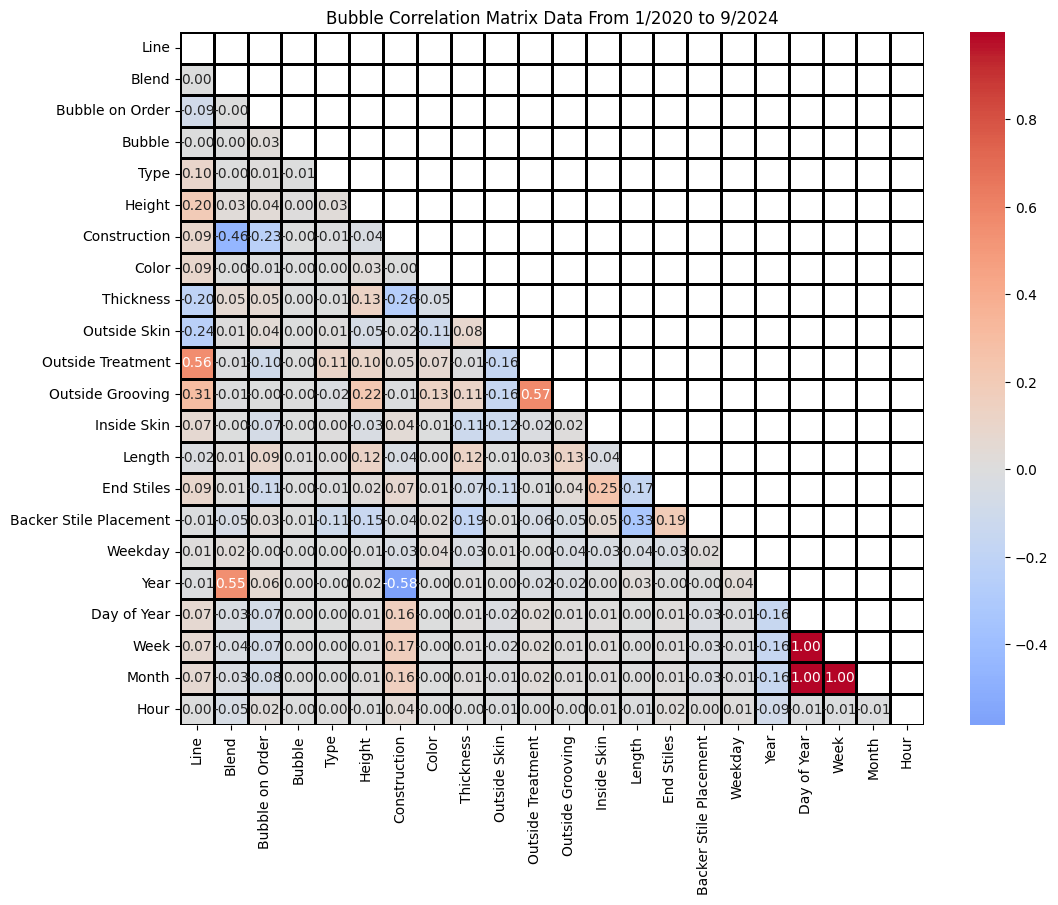

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 9))
matrix = np.triu(df.corr())
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            cbar=True, 
            fmt=".2f",
            center=0,
            linewidths=2, 
            linecolor='black',
            mask=matrix
            )

# Add a title
plt.title(f'Bubble Correlation Matrix Data From {firstDate.month}/{firstDate.year} to {lastDate.month}/{lastDate.year}')

# Show the plot
plt.show()

In [7]:
import haas_section as ht

set(ht.color.values())

{'Almond',
 'American Walnut Woodgrain',
 'Bronze (Terratone)',
 'Brown',
 'Carbon Black',
 'Cedar Plank',
 'Charcole',
 'Cherry Woodgrain',
 'Cool Black',
 'Custom',
 'Embossed Ash Woodgrain',
 'Embossed Cherry Woodgrain',
 'English Oak Woodgrain',
 'Espresso',
 'Gray',
 'Graywood',
 'Hunter Green',
 'Polar White',
 'Sahara Tan',
 'Sandstone',
 'Trinar Almond',
 'Trinar Beige',
 'Trinar Brown',
 'Trinar Polar White',
 'Trinar White'}